In [2]:
# importing organoid metadata

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb

data = pd.read_csv('E:\mask_rcnn\MLR_model\data.csv')
data['Patient_ID'] = data['Patient_ID'].map(lambda x: x.lstrip('SBWCRC00'))
data['Healthy_Tumour'] = data['Healthy_Tumour'].map({'Healthy': 'H', 'Tumour': 'T'})
data['Sample_ID'] = data["Patient_ID"] + data["Healthy_Tumour"]
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.loc[:, ~data.columns.str.contains('^Area')]

# split the organoid_id_brightfield to have a column which indicates which well an organoid is coming from
data['Well'] = data['Organoid_ID_Brightfield'].str.split('.',expand=True)[0]#


# place sample_id col first

cols = list(data)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Well')))
cols.insert(0, cols.pop(cols.index('Sample_ID')))

data = data.loc[:, cols]

data = data[data['Organoid_ID_Detection'].notna()]
data = data[data.Nuclei != 'ND']
data = data[data.Organoid_ID_Detection != '??']
data = data[data.Organoid_ID_Detection != 'na']
data = data.rename(columns={'Organoid_ID_Detection': 'Organoid_ID'})
# fix error
data.Organoid_ID = data.Organoid_ID.replace('1`45', 145)
data.Organoid_ID = data.Organoid_ID.astype(int)
data.Nuclei = data.Nuclei.astype(int)

data

,Sample_ID,Well,Patient_ID,Healthy_Tumour,Morphology,Organoid_ID_Brightfield,Organoid_ID_Detection,Nuclei
0,7H,1,7,H,Cystic,1.1.1,146,82
1,7H,1,7,H,Cystic,1.1.2,153,69
2,7H,1,7,H,Cystic,1.1.3,148,60
3,7H,1,7,H,Cystic,1.1.4,152,83
4,7H,1,7,H,Cystic,1.1.5,153,105
...,...,...,...,...,...,...,...,...
4373,46T,3,46,T,Budded,3.11.4,NaN,61
4374,46T,3,46,T,Budded,3.11.5,161,115
4375,46T,3,46,T,Budded,3.12.1,176,169
4376,46T,3,46,T,Budded,3.12.2,175,110


In [4]:
#get paths of all csv files output by OSCAR
import glob


csv_paths = [x for x in glob.glob(r"E:\mask_rcnn\MLR_model\area_datasets\*.csv")]

# ignore paths which cotain 'VAL'

training_csv_paths = [x for x in csv_paths if 'VAL' not in x]
val_csv_pths = [x for x in csv_paths if 'VAL' in x]


output_list = []

for csv in training_csv_paths:
    sample_id = csv.split('\\')[4].split('_')[0]
    well = csv.split('\\')[4].split('_')[1][-1]
    sample_areas = pd.read_csv(csv)
    temp_df = pd.merge(data[data.Sample_ID.isin([sample_id])][data.Well.isin([well])], sample_areas, on=['Organoid_ID'])
    output_list.append(temp_df)

    

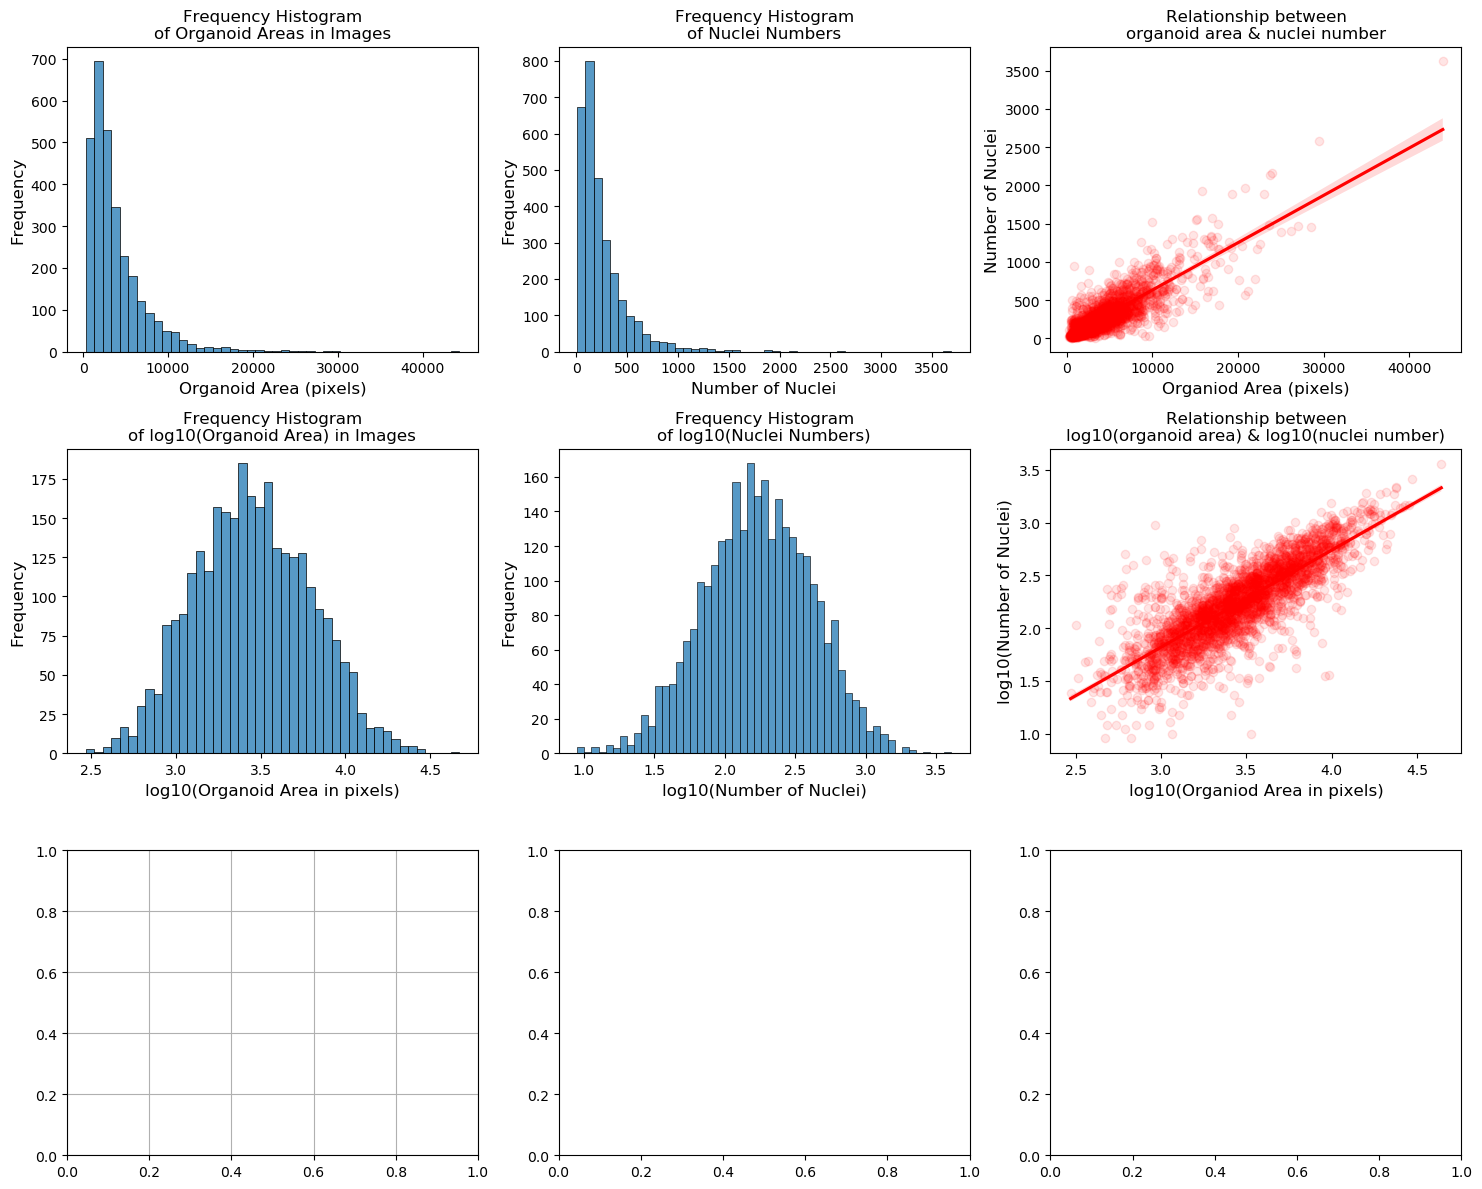

In [7]:
# Assessing distributions of numeric variables and the impact of transformations on variable normality

combined_data = pd.concat(output_list, axis=0)


import matplotlib.pyplot as plt 
import seaborn as sn

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
plt.rcParams['axes.grid'] = False



plt.subplot(3, 3, 1)
sn.histplot(data=combined_data, x="Area (pixels)", binwidth=1000)
plt.title('Frequency Histogram\nof Organoid Areas in Images', fontsize = 12)
plt.xlabel('Organoid Area (pixels)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.subplot(3, 3, 2)
sn.histplot(data=combined_data, x="Nuclei", binwidth=80)
plt.title('Frequency Histogram\nof Nuclei Numbers', fontsize = 12)
plt.xlabel('Number of Nuclei', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)


sn.regplot(data = combined_data, x ='Area (pixels)', y='Nuclei', ax=axes[0, 2], color = 'red',scatter_kws= {'alpha': 0.1})
axes[0, 2].set_xlabel('Organiod Area (pixels)', fontsize=12)
axes[0, 2].set_ylabel('Number of Nuclei', fontsize=12)
axes[0, 2].set_title('Relationship between\norganoid area & nuclei number', fontsize = 12)

# Both cell number and circumference are right-skewed (that is clustered around low values) 
# as such it might be worth performing some transformations to the dataset
# their relationship is also non-linear
# log transformation should solve this


combined_data['Area (pixels)'] = np.log10(combined_data['Area (pixels)']) 
combined_data['Nuclei'] = np.log10(combined_data['Nuclei']) 
combined_data

plt.subplot(3, 3, 4)
sn.histplot(data=combined_data, x="Area (pixels)", binwidth=0.05)
plt.title('Frequency Histogram\nof log10(Organoid Area) in Images', fontsize = 12)
plt.xlabel('log10(Organoid Area in pixels)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.subplot(3, 3, 5)
sn.histplot(data=combined_data, x="Nuclei", binwidth=0.05)
plt.title('Frequency Histogram\nof log10(Nuclei Numbers)', fontsize = 12)
plt.xlabel('log10(Number of Nuclei)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)


sn.regplot(data = combined_data, x ='Area (pixels)', y='Nuclei', ax=axes[1, 2], color = 'red',scatter_kws= {'alpha': 0.1})
axes[1, 2].set_xlabel('log10(Organiod Area in pixels)', fontsize=12)
axes[1, 2].set_ylabel('log10(Number of Nuclei)', fontsize=12)
axes[1, 2].set_title('Relationship between\nlog10(organoid area) & log10(nuclei number)', fontsize = 12)

plt.subplot(3, 3, 7)
plt.grid(True)
fig.tight_layout()
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\effect_of_transportmation_on_data.png', dpi = 600)
plt.show()

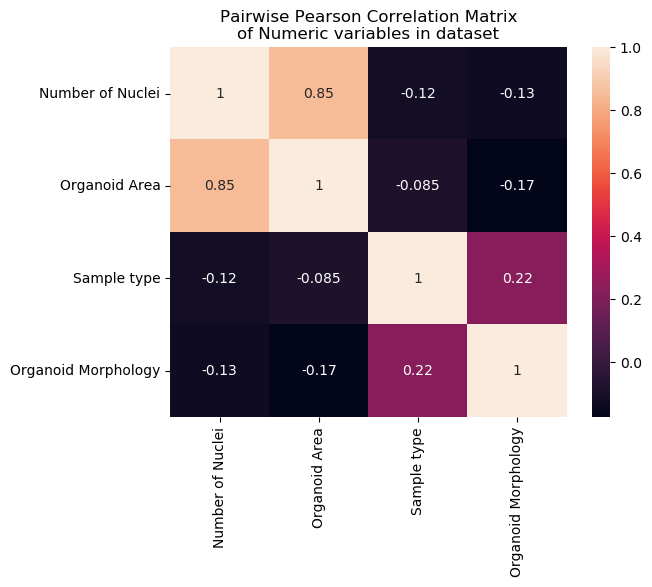

In [11]:
# inital exploratory correlation matrix 
# convert categorical variables to binary numeric variables

import seaborn as sn

sample_type = pd.get_dummies(combined_data['Healthy_Tumour'])
organoid_type  = pd.get_dummies(combined_data['Morphology'])

combined_data['Dummy_tissue_type'] = sample_type['T']
combined_data['Dummy_morphology'] = organoid_type['Budded']

data_numerical = combined_data.drop(['Sample_ID', 'Well', 'Patient_ID','Healthy_Tumour',
                                     'Morphology','Organoid_ID_Brightfield',
                                    'Organoid_ID'], axis=1)

  

# Healthy = 0, Tumour = 1
# Spherical = 0, Irregular = 1

data_numerical = combined_data.drop(['Sample_ID', 'Well', 'Patient_ID','Healthy_Tumour',
                                     'Morphology','Organoid_ID_Brightfield',
                                    'Organoid_ID'], axis=1)
data_numerical = data_numerical.rename(columns={"Dummy_morphology": "Organoid Morphology", "Dummy_tissue_type": "Sample type"})


data_numerical.rename(columns={'Nuclei': 'Number of Nuclei', 'Area (pixels)': 'Organoid Area'}, inplace=True)


corr_matrix = data_numerical.corr(method = 'pearson')

sn.heatmap(corr_matrix, annot=True)
plt.title('Pairwise Pearson Correlation Matrix\nof Numeric variables in dataset')
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\correlation_matrix_of_numeric_variables.png', dpi = 600,bbox_inches = "tight")
plt.show()

In [12]:
# Significance values for pearson correlations

from scipy.stats import pearsonr
pval = data_numerical.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr_matrix.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
pval

,Number of Nuclei,Organoid Area,Sample type,Organoid Morphology
Number of Nuclei,0.000000e+00,0.000000e+00,2.437289e-10,8.337794e-13
Organoid Area,0.000000e+00,0.000000e+00,3.336351e-06,6.114642e-22
Sample type,2.437289e-10,3.336351e-06,0.000000e+00,1.960155e-35
Organoid Morphology,8.337794e-13,6.114642e-22,1.960155e-35,0.000000e+00


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm


Index(['Number of Nuclei', 'Organoid Area', 'Sample type',
       'Organoid Morphology'],
      dtype='object')

In [14]:
# Generate eMLR model
x = data_numerical[['Organoid Area', 'Sample type', 'Organoid Morphology']]
y = data_numerical['Number of Nuclei']

x['Organoid Area'] = np.log10(x['Organoid Area'])
y = np.log10(y)

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant
 
mlr = sm.OLS(y, x).fit()



Intercept: 
 -0.9473452061902279
Coefficients: 
 [ 0.92394822 -0.02627018  0.02340238]


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
# save the model to disk for uploading to server later
import pickle
filename = r'E:\mask_rcnn\MLR_model\mlr_model.sav'
pickle.dump(mlr, open(filename, 'wb'))

In [16]:
#load model from disk
loaded_model = pickle.load(open(filename, 'rb'))
predictions = mlr.predict(x) 
 
print_model = mlr.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:       Number of Nuclei   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     1977.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        18:35:13   Log-Likelihood:                 244.47
No. Observations:                2985   AIC:                            -480.9
Df Residuals:                    2981   BIC:                            -456.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9473    

In [18]:
# assesssing model accuracy on training data


data_with_predications = pd.concat([data_numerical,10** predictions], axis = 1)
#data_with_predications = pd.concat([data_numerical,predictions], axis = 1)
data_with_predications = data_with_predications.rename(columns={0: "Nuclei_prediction"})


# scatter plot of data
# converting numeric variables back to categorical

data_with_predications['Organoid Morphology'] = np.where(data_with_predications['Organoid Morphology'] == 0, 
                                                   'Cystic', 
                                                   data_with_predications['Organoid Morphology'])

data_with_predications['Organoid Morphology'] = np.where(data_with_predications['Organoid Morphology'] == '1', 
                                                   'Budded', 
                                                   data_with_predications['Organoid Morphology'])

data_with_predications['Sample type'] = np.where(data_with_predications['Sample type'] == 0, 
                                                   'Healthy', 
                                                   data_with_predications['Sample type'])

data_with_predications['Sample type'] = np.where(data_with_predications['Sample type'] == '1', 
                                                   'Tumour', 
                                                   data_with_predications['Sample type'])
data_with_predications['real_cell_number'] = data_with_predications['Number of Nuclei'] 
data_with_predications['real_cell_number_predicition'] =  data_with_predications['Nuclei_prediction'] 

data_with_predications

,Number of Nuclei,Organoid Area,Sample type,Organoid Morphology,Nuclei_prediction
0,111.0,2779.0,1,1,170.514645
1,70.0,1816.0,1,1,115.090977
2,99.0,2392.0,1,1,148.452449
3,34.0,1088.0,1,1,71.692687
4,40.0,918.0,1,1,61.277384
...,...,...,...,...,...
14,153.0,2784.0,1,1,170.798085
15,61.0,904.0,1,1,60.413438
16,123.0,2133.0,1,1,133.537170
17,110.0,2410.0,1,1,149.484313


In [20]:
# Generate absolute mean deviation from real nuclei numbers

data_with_predications['real_area'] = data_with_predications['Organoid Area']
data_with_predications['predicition_devition'] = data_with_predications['real_cell_number'] - data_with_predications['real_cell_number_predicition'] 
data_with_predications['predicition_devition'].abs().mean()

82.39003920674126

In [21]:
#confidence interval for reporting

import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mean_confidence_interval(data_with_predications['predicition_devition'].abs())

(82.39003920674129, 78.38209028887523, 86.39798812460735)

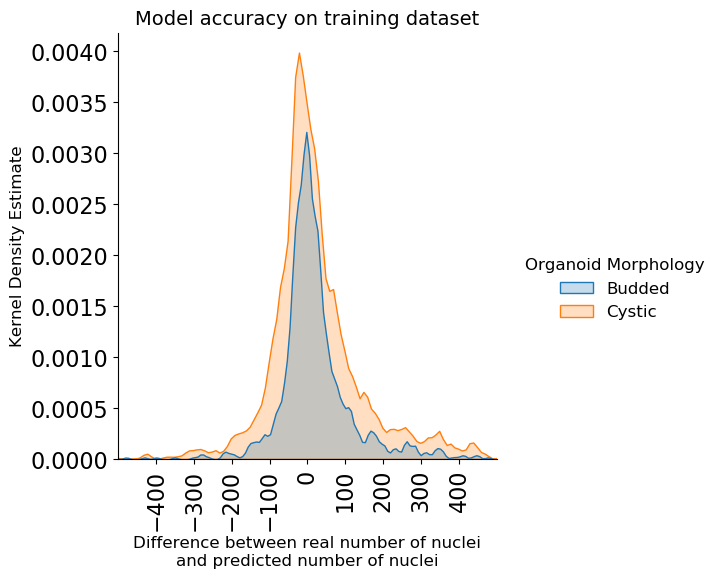

In [23]:
#plotting of model accuracy on training data

params = {'legend.fontsize': 12,
          'legend.handlelength': 2,
         'legend.title_fontsize':12}
plt.rcParams.update(params)


sn.displot(data_with_predications, x="predicition_devition", 
           hue = 'Organoid Morphology',
           kind ='kde',
           bw_adjust=.25,
          fill = True)
plt.xlim(-500,500)
plt.xticks(np.arange(-400, 500, step=100))  # Set label locations.
plt.xlabel('Difference between real number of nuclei\nand predicted number of nuclei', fontsize = 12)
plt.ylabel('Kernel Density Estimate', fontsize = 12)
plt.title('Model accuracy on training dataset', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.xticks(rotation=90)
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\model_accuracy_on_training_dataset.png', dpi=1200,bbox_inches = "tight")

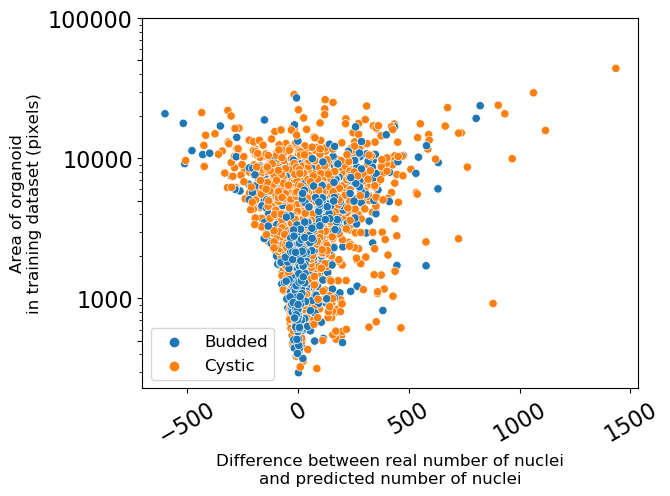

In [25]:
#plotting deviation vs organoid area
fig1, ax1 = plt.subplots()
sn.scatterplot(data=data_with_predications, x="predicition_devition", y="real_area", hue = 'Organoid Morphology')
ax1.set_yscale('log')
ax1.set_yticks([500,1000,5000,10000,50000,100000])
ax1.set_yticklabels(['',1000,'',10000,'',100000])
plt.xlabel('Difference between real number of nuclei\nand predicted number of nuclei', fontsize =12 )
plt.ylabel('Area of organoid\nin training dataset (pixels)', fontsize =12 )
plt.legend(loc = 3)
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.xticks(rotation=30)
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\deviation_from_real_number_vs_organoid_area.png', dpi=1200,bbox_inches = "tight")
plt.show()

In [26]:
data_with_predications['sample_id'] = combined_data['Sample_ID']
data_with_predications['well'] = combined_data['Well']
data_with_predications['Organoid_ID'] = combined_data['Organoid_ID']
data_with_predications['Organoid_ID_Brightfield'] = combined_data['Organoid_ID_Brightfield']


,Number of Nuclei,Organoid Area,Sample type,Organoid Morphology,Nuclei_prediction,real_cell_number,real_cell_number_predicition,real_area,predicition_devition,sample_id,well,Organoid_ID,Organoid_ID_Brightfield
10,565.0,20828.0,Healthy,Budded,1164.833659,565.0,1164.833659,20828.0,-599.833659,54H,4,52,4.4.3
13,431.0,17796.0,Tumour,Budded,948.123274,431.0,948.123274,17796.0,-517.123274,54T,2,40,2.4.6
2,35.0,9175.0,Healthy,Budded,546.134993,35.0,546.134993,9175.0,-511.134993,65H,3,20,3.1.3
26,36.0,9658.0,Healthy,Cystic,542.605557,36.0,542.605557,9658.0,-506.605557,67H,2,250,2.8.2


In [27]:
# preparing the validation dataset
val_list = []

for csv in val_csv_pths:
    sample_id = csv.split('\\')[4].split('_')[0]
    well =csv.split('\\')[4].split('_')[1].split(' ')[0][-1]
    sample_areas = pd.read_csv(csv)
    temp_df = pd.merge(data[data.Sample_ID.isin([sample_id])][data.Well.isin([well])], sample_areas, on=['Organoid_ID'])
    val_list.append(temp_df)

val_data = pd.concat(val_list, axis=0)
val_data

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Sample_ID,Well,Patient_ID,Healthy_Tumour,Morphology,Organoid_ID_Brightfield,Organoid_ID,Nuclei,Area (pixels)
0,46T,1,46,T,Budded,1.1.1,0,356,944
1,46T,1,46,T,Budded,1.1.2,38,98,1414
2,46T,1,46,T,Budded,1.1.3,37,290,848
3,46T,1,46,T,Budded,1.1.4,36,67,503
4,46T,1,46,T,Budded,1.1.5,1,171,4668
...,...,...,...,...,...,...,...,...,...
46,94H,3,94,H,Cystic,3.5.8,238,102,1843
47,94H,3,94,H,Cystic,3.5.9,239,59,1481
48,94H,3,94,H,Cystic,3.5.10,243,66,1471
49,94H,3,94,H,Cystic,3.5.11,245,40,1176


In [28]:
import pickle
filename = r'E:\mask_rcnn\MLR_model\mlr_model.sav'
#load model from disk
loaded_model = pickle.load(open(filename, 'rb'))

sample_type = pd.get_dummies(val_data['Healthy_Tumour'])
organoid_type  = pd.get_dummies(val_data['Morphology'])

val_data['Dummy_tissue_type'] = sample_type['T']
val_data['Dummy_morphology'] = organoid_type['Budded']


val_data_numerical = val_data.drop(['Sample_ID', 'Well', 'Patient_ID','Healthy_Tumour',
                                     'Morphology','Organoid_ID_Brightfield',
                                    'Organoid_ID'], axis=1)
val_data_numerical = val_data_numerical.rename(columns={"Dummy_morphology": "Organoid Morphology", "Dummy_tissue_type": "Sample type"})

val_data_numerical['Area (pixels)'] = np.log10(val_data_numerical['Area (pixels)']) 
val_data_numerical['Nuclei'] = np.log10(val_data_numerical['Nuclei']) 

x = val_data_numerical[['Area (pixels)', 'Sample type', 'Organoid Morphology']]
# add constant
# with statsmodels
x = sm.add_constant(x) # adding a constant

val_predictions = mlr.predict(x) 

val_with_predications = pd.concat([val_data_numerical, 10** val_predictions], axis = 1)
#val_with_predications = pd.concat([val_data_numerical, val_predictions], axis = 1)
val_with_predications = val_with_predications.rename(columns={0: "Nuclei_prediction"})
val_with_predications['Nuclei'] = 10 ** val_with_predications['Nuclei']
val_with_predications

,Nuclei,Area (pixels),Sample type,Organoid Morphology,Nuclei_prediction
0,356.0,2.974972,1,1,62.879209
1,98.0,3.150449,1,1,91.335396
2,290.0,2.928396,1,1,56.947299
3,67.0,2.701568,1,1,35.147620
4,171.0,3.669131,1,1,275.342917
...,...,...,...,...,...
46,102.0,3.265525,0,0,117.444077
47,59.0,3.170555,0,0,95.958511
48,66.0,3.167613,0,0,95.359703
49,40.0,3.070407,0,0,77.544710


[Text(0.5, 1.0, 'Validation - Healthy samples')]

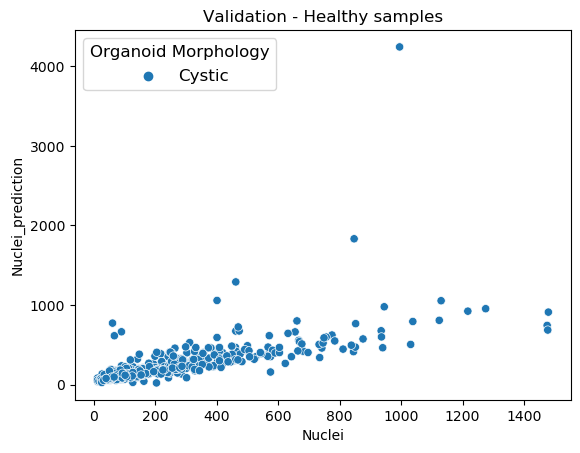

In [29]:
val_with_predications['Organoid Morphology'] = np.where(val_with_predications['Organoid Morphology'] == 0, 
                                                   'Cystic', 
                                                   val_with_predications['Organoid Morphology'])

val_with_predications['Organoid Morphology'] = np.where(val_with_predications['Organoid Morphology'] == '1', 
                                                   'Budded', 
                                                   val_with_predications['Organoid Morphology'])

val_with_predications['Sample type'] = np.where(val_with_predications['Sample type'] == 0, 
                                                   'Healthy', 
                                                   val_with_predications['Sample type'])

val_with_predications['Sample type'] = np.where(val_with_predications['Sample type'] == '1', 
                                                   'Tumour', 
                                                   val_with_predications['Sample type'])


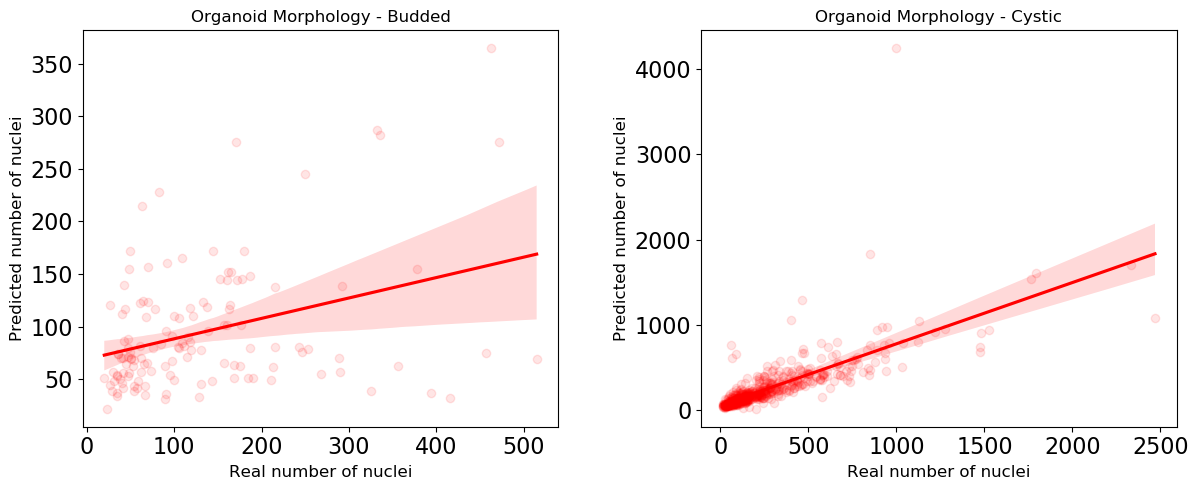

In [31]:
# plot deviation of predicted values from real values

val_with_predications['real_cell_number'] = val_with_predications['Nuclei'] 
val_with_predications['real_cell_number_predicition'] = val_with_predications['Nuclei_prediction'] 

val_with_predications['predicition_devition'] = val_with_predications['real_cell_number'] - val_with_predications['real_cell_number_predicition'] 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams['axes.grid'] = False
sn.regplot(data = val_with_predications[val_with_predications['Organoid Morphology'] == 'Budded'], x ='real_cell_number', y='real_cell_number_predicition', ax=axes[0], 
           color = 'red',scatter_kws= {'alpha': 0.1})
axes[0].tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
axes[0].set_xlabel('Real number of nuclei', fontsize=12)
axes[0].set_ylabel('Predicted number of nuclei', fontsize=12)
axes[0].set_title('Organoid Morphology - Budded', fontsize = 12)


sn.regplot(data = val_with_predications[val_with_predications['Organoid Morphology'] == 'Cystic'], x ='real_cell_number', y='real_cell_number_predicition', ax=axes[1], 
           color = 'red',scatter_kws= {'alpha': 0.1})
axes[1].set_xlabel('Real number of nuclei', fontsize=12)
axes[1].set_ylabel('Predicted number of nuclei', fontsize=12)
axes[1].set_title('Organoid Morphology - Cystic', fontsize = 12)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust the space between the plots

plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\validation_dataset_real_vs_predicted_number_of_nuclei.png', dpi=1200,bbox_inches = "tight")

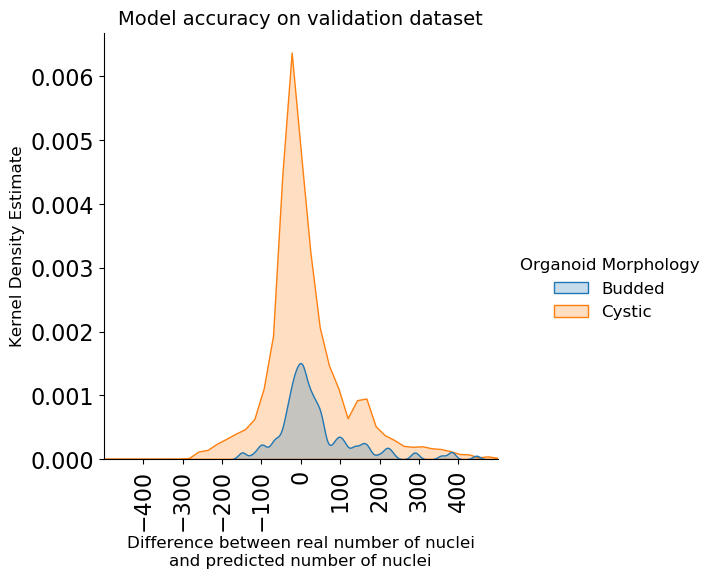

In [32]:
# Distriubtuions of model deviation

sn.displot(val_with_predications, x="predicition_devition", 
           hue = 'Organoid Morphology',
           kind ='kde',
           bw_adjust=.25,
          fill = True)
plt.xlim(-500,500)
plt.xticks(np.arange(-400, 500, step=100))  # Set label locations.
plt.xlabel('Difference between real number of nuclei\nand predicted number of nuclei',fontsize=12)
plt.ylabel('Kernel Density Estimate',fontsize=12)
plt.title('Model accuracy on validation dataset',fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.xticks(rotation=90)
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\validation_dataset_distribution_of_model_deviation.png', dpi=1200,bbox_inches = "tight")

# sn.displot(val_with_predications, x="predicition_devition", stat="density", bins = 40).set(title='Deviation of predicted number of cells from real number of cells')
# plt.xlim(-1000,1000)
# plt.xlabel('Deviation (number of cells)')
# plt.ylabel('Density')

In [33]:
#confidence interval for reporting

mean_confidence_interval(val_with_predications['predicition_devition'].abs())

(86.05927672282058, 73.73714243685168, 98.38141100878948)

In [36]:
# assess the deviation at the level of the entire well 

val_data_predictions_with_ID = val_with_predications.copy()

val_data_predictions_with_ID['Sample_ID'] = val_data['Sample_ID']
val_data_predictions_with_ID['Well'] = val_data['Well']


deviation_at_well_level = val_data_predictions_with_ID.groupby(['Sample_ID','Well','Organoid Morphology']).sum()

deviation_at_well_level['percentage_deviation'] = deviation_at_well_level['predicition_devition']/deviation_at_well_level['real_cell_number']


deviation_at_well_level = deviation_at_well_level.reset_index()
#logged
deviation_at_well_level['percentage_deviation'].describe()
deviation_at_well_level['percentage_deviation'].abs().mean()

0.16168553875212816

In [37]:
# 95% CI for reporting
mean_confidence_interval(deviation_at_well_level['percentage_deviation'].abs())

(0.16168553875212816, 0.11849501809497823, 0.20487605940927808)

In [38]:
barplot_df = pd.melt(deviation_at_well_level, id_vars=['Sample_ID','Well','Organoid Morphology'], value_vars=['real_cell_number', 'real_cell_number_predicition'])
barplot_df['id'] = barplot_df['Sample_ID'] + '_' + barplot_df['Well']
barplot_df = barplot_df.sort_values(by=['value'],ascending=False)


barplot_df['variable']= barplot_df['variable'].replace('real_cell_number', 'Real')
barplot_df['variable'] = barplot_df['variable'].replace('real_cell_number_predicition', 'Predicted')
barplot_df = barplot_df.rename(columns={'variable': 'Nuclei number type', 'oldName2': 'newName2'})
barplot_df

,Sample_ID,Well,Organoid Morphology,Nuclei number type,value,id
28,88H,1,Cystic,Predicted,21366.089478,88H_1
10,88H,1,Cystic,Real,18984.000000,88H_1
15,94H,1,Cystic,Real,16388.000000,94H_1
33,94H,1,Cystic,Predicted,13596.838887,94H_1
4,86H,2,Cystic,Real,12736.000000,86H_2
16,94H,2,Cystic,Real,12653.000000,94H_2
6,86H,4,Cystic,Real,12031.000000,86H_4
29,88H,2,Cystic,Predicted,11624.095225,88H_2
21,86H,1,Cystic,Predicted,11016.865206,86H_1
22,86H,2,Cystic,Predicted,10920.765668,86H_2


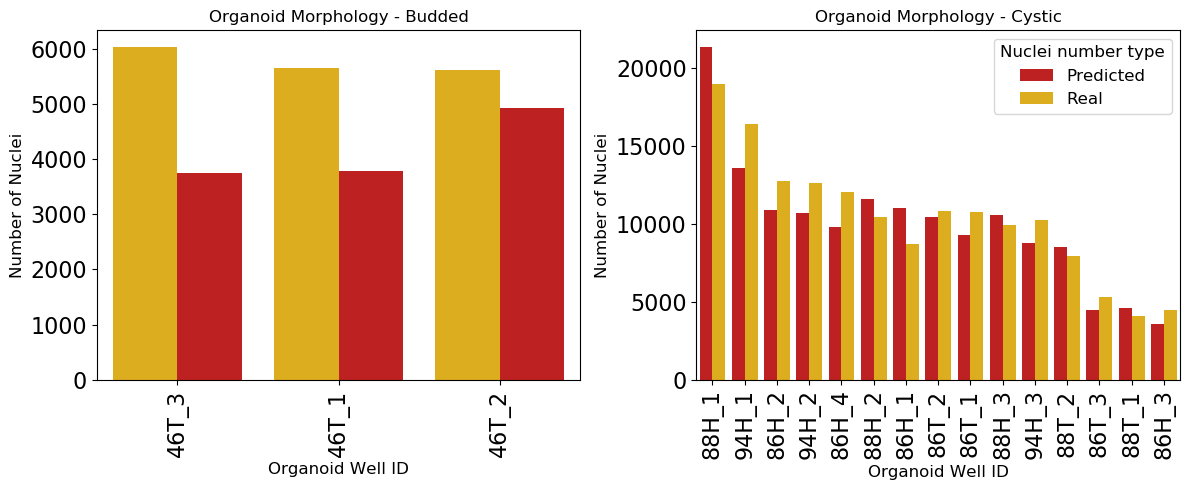

In [39]:
palette = {'Predicted': "#D80707", 'Real': "#FDBD00"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.rcParams['axes.grid'] = False
br_a = sn.barplot(data=barplot_df[barplot_df['Organoid Morphology'] == 'Budded'], 
                  x='id', 
                  y ='value', 
                  hue ='Nuclei number type',  
                  ax = axes[0],
                 palette = palette)
axes[0].set_xlabel('Organoid Well ID', fontsize=12)
axes[0].set_ylabel('Number of Nuclei', fontsize=12)
axes[0].set_title('Organoid Morphology - Budded', fontsize = 12)
axes[0].tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size

br_a.legend_.remove()
for item in br_a.get_xticklabels():
    item.set_rotation(90)



br_b = sn.barplot(data=barplot_df[barplot_df['Organoid Morphology'] == 'Cystic'], 
                  x='id', 
                  y ='value', 
                  hue ='Nuclei number type',  
                  ax = axes[1],
                 palette = palette)
axes[1].set_xlabel('Organoid Well ID', fontsize=12)
axes[1].set_ylabel('Number of Nuclei', fontsize=12)
axes[1].set_title('Organoid Morphology - Cystic', fontsize = 12)
for item in br_b.get_xticklabels():
    item.set_rotation(90)
axes[1].tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size

    
plt.subplots_adjust(wspace=0.3)  # Adjust the space between the plots

fig.tight_layout()
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\well_level_accuracy_validation_dataset.png', dpi = 1200)

In [40]:
pancreatic_data = pd.read_csv(r'E:\mask_rcnn\MLR_model\pancreatic_oragnoids_data.csv')
pancreatic_data['Healthy_Tumour'] = pancreatic_data['Healthy_Tumour'].map({'Healthy': 'H', 'Tumour': 'T'})
pancreatic_data = pancreatic_data.loc[:, ~pancreatic_data.columns.str.contains('^Unnamed')]
pancreatic_data = pancreatic_data.loc[:, ~pancreatic_data.columns.str.contains('^Area')]

# split the organoid_id_brightfield to have a column which indicates which well an organoid is coming from
pancreatic_data['Well'] = pancreatic_data['Organoid_ID_Brightfield'].str.split('.',expand=True)[0]#

pancreatic_data = pancreatic_data[pancreatic_data['Organoid_ID_Detection'].notna()]
pancreatic_data = pancreatic_data[pancreatic_data.Nuclei != 'ND']
pancreatic_data = pancreatic_data[pancreatic_data.Organoid_ID_Detection != '??']
pancreatic_data = pancreatic_data[pancreatic_data.Organoid_ID_Detection != 'na']
pancreatic_data = pancreatic_data.rename(columns={'Organoid_ID_Detection': 'Organoid_ID'})
# fix error
pancreatic_data.Organoid_ID = pancreatic_data.Organoid_ID.astype(int)
pancreatic_data.Nuclei = pancreatic_data.Nuclei.astype(int)

# pancreatic dataset 

pancreatic_csv_paths = [x for x in glob.glob(r"E:\mask_rcnn\MLR_model\pancreatic_area_datasets\*.csv")]


pan_list = []

for csv in pancreatic_csv_paths:
    sample_id = csv.split('\\')[4].split('_')[0]
    well =csv.split('\\')[4].split('_')[1].split(' ')[0][-1]
    sample_areas = pd.read_csv(csv)
    temp_df = pd.merge(pancreatic_data[pancreatic_data.Patient_ID.isin([sample_id])][pancreatic_data.Well.isin([well])], sample_areas, on=['Organoid_ID'])
    pan_list.append(temp_df)

pancreatic_data_full = pd.concat(pan_list, axis=0)
pancreatic_data_full


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Patient_ID,Healthy_Tumour,Morphology,Organoid_ID_Brightfield,Organoid_ID,Nuclei,Well,Area (pixels)
0,PM030,T,Cystic,1.1.1,104,815,1,11352
1,PM030,T,Cystic,1.1.2,136,138,1,2311
2,PM030,T,Cystic,1.1.3,137,477,1,6023
3,PM030,T,Cystic,1.1.5,99,676,1,10196
4,PM030,T,Cystic,1.1.6,132,139,1,2120
...,...,...,...,...,...,...,...,...
9,PM038,T,Cystic,4.3.3,5,73,4,1165
10,PM038,T,Cystic,4.3.4,9,117,4,1674
11,PM038,T,Cystic,4.3.5,6,24,4,1879
12,PM038,T,Cystic,4.3.6,2,108,4,915


In [41]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
filename = r'E:\mask_rcnn\MLR_model\mlr_model.sav'
#load model from disk
loaded_model = pickle.load(open(filename, 'rb'))

sample_type = pd.get_dummies(pancreatic_data_full['Healthy_Tumour'])
organoid_type  = pd.get_dummies(pancreatic_data_full['Morphology'])

pancreatic_data_full['Dummy_tissue_type'] = sample_type['T']
pancreatic_data_full['Dummy_morphology'] = 0


pancreatic_data_numerical = pancreatic_data_full.drop(['Well', 'Patient_ID','Healthy_Tumour',
                                     'Morphology','Organoid_ID_Brightfield',
                                    'Organoid_ID'], axis=1)
pancreatic_data_numerical = pancreatic_data_full.rename(columns={"Dummy_morphology": "Organoid Morphology", "Dummy_tissue_type": "Sample type"})

pancreatic_data_numerical['Area (pixels)'] = np.log10(pancreatic_data_numerical['Area (pixels)']) 
pancreatic_data_numerical['Nuclei'] = np.log10(pancreatic_data_numerical['Nuclei']) 

x = pancreatic_data_numerical[['Area (pixels)', 'Sample type', 'Organoid Morphology']]
# add constant
# with statsmodels
x = sm.add_constant(x,has_constant='add') # adding a constant


pancreatic_predictions = loaded_model.predict(x) 


pancreatic_with_predications = pd.concat([pancreatic_data_numerical, pancreatic_predictions], axis = 1)
pancreatic_with_predications = pancreatic_with_predications.rename(columns={0: "Nuclei_prediction"})


pancreatic_with_predications['Organoid Morphology'] = np.where(pancreatic_with_predications['Organoid Morphology'] == 0, 
                                                   'Cystic', 
                                                   pancreatic_with_predications['Organoid Morphology'])

pancreatic_with_predications['Organoid Morphology'] = np.where(pancreatic_with_predications['Organoid Morphology'] == 1, 
                                                   'Budded', 
                                                   pancreatic_with_predications['Organoid Morphology'])

pancreatic_with_predications['Sample type'] = np.where(pancreatic_with_predications['Sample type'] == 0, 
                                                   'Healthy', 
                                                   pancreatic_with_predications['Sample type'])

pancreatic_with_predications['Sample type'] = np.where(pancreatic_with_predications['Sample type'] == '1', 
                                                   'Tumour', 
                                                   pancreatic_with_predications['Sample type'])

pancreatic_with_predications

,Patient_ID,Healthy_Tumour,Morphology,Organoid_ID_Brightfield,Organoid_ID,Nuclei,Well,Area (pixels),Sample type,Organoid Morphology,Nuclei_prediction
0,PM030,T,Cystic,1.1.1,104,2.911158,1,4.055072,Tumour,Cystic,2.773062
1,PM030,T,Cystic,1.1.2,136,2.139879,1,3.363800,Tumour,Cystic,2.134362
2,PM030,T,Cystic,1.1.3,137,2.678518,1,3.779813,Tumour,Cystic,2.518736
3,PM030,T,Cystic,1.1.5,99,2.829947,1,4.008430,Tumour,Cystic,2.729966
4,PM030,T,Cystic,1.1.6,132,2.143015,1,3.326336,Tumour,Cystic,2.099747
...,...,...,...,...,...,...,...,...,...,...,...
9,PM038,T,Cystic,4.3.3,5,1.863323,4,3.066326,Tumour,Cystic,1.859511
10,PM038,T,Cystic,4.3.4,9,2.068186,4,3.223755,Tumour,Cystic,2.004968
11,PM038,T,Cystic,4.3.5,6,1.380211,4,3.273927,Tumour,Cystic,2.051323
12,PM038,T,Cystic,4.3.6,2,2.033424,4,2.961421,Tumour,Cystic,1.762584


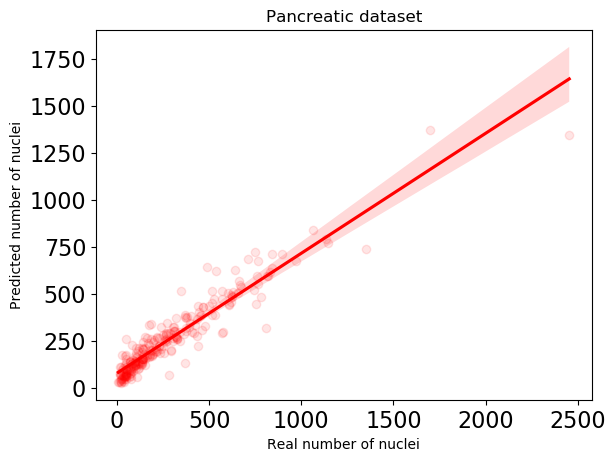

In [42]:
# plot deviation of predicted values from real values

pancreatic_with_predications['real_cell_number'] = 10 ** pancreatic_with_predications['Nuclei'] 
pancreatic_with_predications['real_cell_number_predicition'] = 10 ** pancreatic_with_predications['Nuclei_prediction'] 

pancreatic_with_predications['predicition_devition'] = pancreatic_with_predications['real_cell_number'] - pancreatic_with_predications['real_cell_number_predicition'] 


sn.regplot(data = pancreatic_with_predications, 
           x ='real_cell_number', 
           y='real_cell_number_predicition',
           color = 'red',
           scatter_kws= {'alpha': 0.1})
plt.xlabel('Real number of nuclei')
plt.ylabel('Predicted number of nuclei')
plt.title('Pancreatic dataset')
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size


plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\pancreatic_dataset_real_vs_predicted_number_of_nuclei.png', dpi=1200,bbox_inches = "tight")

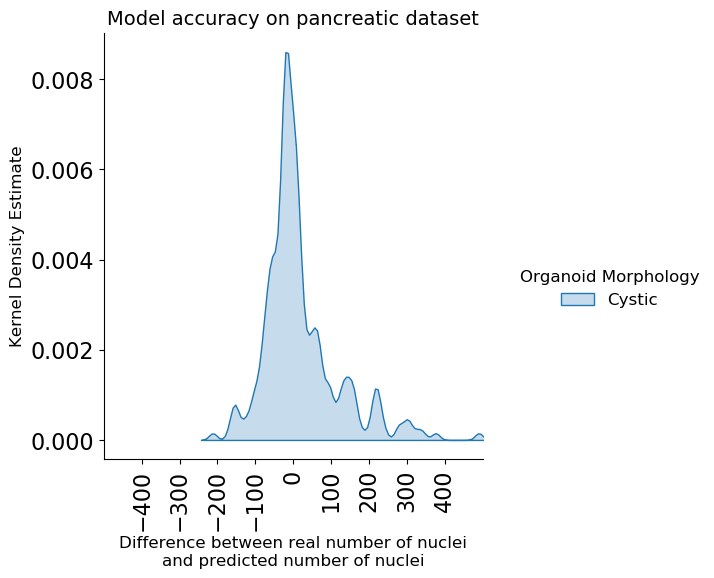

In [43]:
# Distriubtuions of model deviation

sn.displot(pancreatic_with_predications, x="predicition_devition", 
           hue = 'Organoid Morphology',
           kind ='kde',
           bw_adjust=.25,
          fill = True)
plt.xlim(-500,500)
plt.xticks(np.arange(-400, 500, step=100))  # Set label locations.
plt.xlabel('Difference between real number of nuclei\nand predicted number of nuclei',fontsize=12)
plt.ylabel('Kernel Density Estimate',fontsize=12)
plt.title('Model accuracy on pancreatic dataset',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.xticks(rotation=90)
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\pancreatic_dataset_distribution_of_model_deviation.png', dpi=1200,bbox_inches = "tight")


In [44]:
# assess the deviation at the level of the entire well 

pancreatic_deviation_at_well_level = pancreatic_with_predications.groupby(['Patient_ID','Well']).sum()

pancreatic_deviation_at_well_level['percentage_deviation'] = pancreatic_deviation_at_well_level['predicition_devition']/pancreatic_deviation_at_well_level['real_cell_number']

pancreatic_deviation_at_well_level = pancreatic_deviation_at_well_level.reset_index()
pancreatic_deviation_at_well_level['percentage_deviation'].abs().mean()


0.1653370652060203

In [45]:
# 95% CI for reporting
mean_confidence_interval(pancreatic_deviation_at_well_level['percentage_deviation'].abs())

(0.1653370652060203, 0.07150022376006927, 0.2591739066519713)

In [ ]:

pancreatic_barplot_df = pd.melt(pancreatic_deviation_at_well_level, id_vars=['Patient_ID','Well'], value_vars=['real_cell_number', 'real_cell_number_predicition'])
pancreatic_barplot_df['id'] = pancreatic_barplot_df['Patient_ID'] + '_' + pancreatic_barplot_df['Well']
pancreatic_barplot_df = pancreatic_barplot_df.sort_values(by=['value'],ascending=False)



pancreatic_barplot_df['variable']= pancreatic_barplot_df['variable'].replace('real_cell_number', 'Real')
pancreatic_barplot_df['variable'] = pancreatic_barplot_df['variable'].replace('real_cell_number_predicition', 'Predicted')
pancreatic_barplot_df = pancreatic_barplot_df.rename(columns={'variable': 'Nuclei number type', 'oldName2': 'newName2'})
pancreatic_barplot_df


In [379]:
pancreatic_deviation_at_well_level

,Patient_ID,Well,Organoid_ID,Nuclei,Area (pixels),Nuclei_prediction,real_cell_number,real_cell_number_predicition,predicition_devition,percentage_deviation
0,PM030,1,6048,149.186231,224.507690,147.069327,23597.0,18741.187886,4855.812114,0.205781
1,PM030,2,2791,98.988098,151.811740,100.347956,15315.0,14295.551093,1019.448907,0.066565
2,PM030,3,2018,70.193891,107.190377,70.803512,10915.0,10070.800634,844.199366,0.077343
3,PM030,4,1634,67.923086,100.632747,65.718216,9316.0,7022.091615,2293.908385,0.246233
4,PM038,1,1270,57.192631,97.899459,62.219185,4877.0,5696.334964,-819.334964,-0.168000
5,PM038,2,1353,62.135175,108.116435,68.738296,4109.0,5558.486240,-1449.486240,-0.352759
6,PM038,3,1099,38.353689,66.482379,41.953968,2451.0,2946.143003,-495.143003,-0.202017
7,PM038,4,249,26.039525,45.406832,28.322946,1826.0,1818.698572,7.301428,0.003999


In [378]:
pancreatic_deviation_at_well_level['percentage_deviation'].abs().mean()


0.1653370652060203

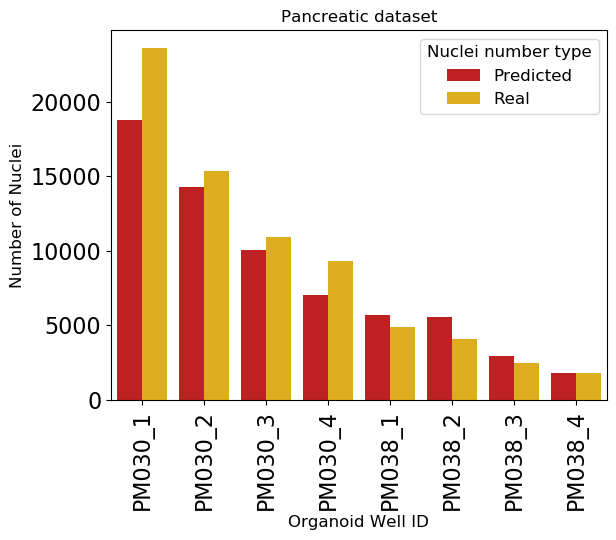

In [425]:
palette = {'Predicted': "#D80707", 'Real': "#FDBD00"}
hue_order = ['Predicted', 'Real']

br_a = sn.barplot(data=pancreatic_barplot_df, 
                  x='id', 
                  y ='value', 
                  hue ='Nuclei number type',
                  hue_order = hue_order,
                 palette = palette)
plt.xlabel('Organoid Well ID', fontsize=12)
plt.ylabel('Number of Nuclei', fontsize=12)
plt.title('Pancreatic dataset', fontsize = 12)

for item in br_a.get_xticklabels():
    item.set_rotation(90)
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.savefig(r'E:\mask_rcnn\MLR_model\figure_outputs\well_level_accuracy_pancreatic_dataset.png', dpi = 1200,bbox_inches = "tight")

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


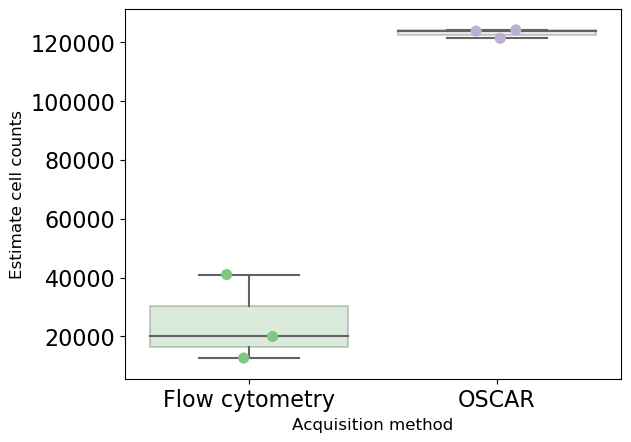

In [434]:
# Figures comparing the cell counting in flow cytometry and the cell counting pipeline

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

#palette = {'Flow cytometry': "#3368FF", 'Computational pipeline': "#34A52C"}
hue_order = ['Flow cytometry', 'OSCAR']

# first compare the different steps

different_steps = pd.read_csv(r'E:\Organoid_Images\051223_cellcount_comparisons.csv')



different_steps['Acquisition method'] =different_steps['Acquisition method'].replace('Computational pipeline', 'OSCAR')

different_steps["Cell_count"] = pd.to_numeric(different_steps["Cell_count"])


sn.boxplot(data=different_steps, 
                  x='Acquisition method', 
                  y ='Cell_count',
                hue_order = hue_order,
                palette = 'Accent',
            boxprops=dict(alpha=.3))
sn.stripplot(data=different_steps, 
                  x='Acquisition method', 
                  y ='Cell_count',
                hue_order = hue_order,
                 palette = 'Accent', size=8)
plt.xlabel('Acquisition method', fontsize=12)
plt.ylabel('Estimate cell counts', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.savefig(r'E:\Organoid_paper_final_images\flow_vs_ocsar.png', dpi=250,bbox_inches = "tight")

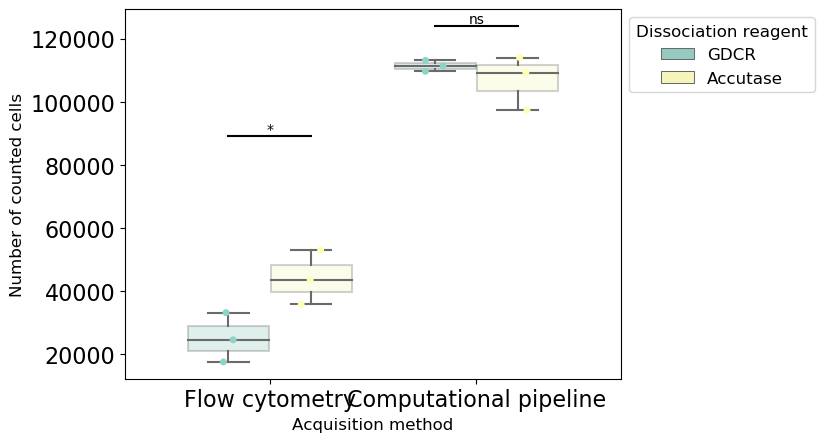

In [432]:
different_treatments = pd.read_csv(r'E:\Organoid_Images\121223_cellcount_treatment_comparisons.csv')

ax2 = sn.stripplot(data=different_treatments, 
                x = 'Acquisition method',
                  hue='Dissociation Reagent', 
                  y ='Count',
                   palette = 'Set3',
            dodge=True)
ax = sn.boxplot(data=different_treatments, 
                x = 'Acquisition method',
                  hue='Dissociation Reagent', 
                  y ='Count',
                  palette = 'Set3',
            boxprops=dict(alpha=.3))



x1, x2 = 0.8, 1.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = different_treatments['Count'].max() + 10000, 2, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

x3, x4 = -0.2, 0.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = different_treatments['Count'].max() - 25000, 2, 'k'

plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h, "*", ha='center', va='bottom', color=col)

plt.xlabel('Acquisition method', fontsize=12)
plt.ylabel('Number of counted cells', fontsize=12)


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Dissociation reagent')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tick_params(axis='both', which='major', labelsize=16)  # Change 14 to your desired size
plt.savefig(r'E:\Organoid_paper_final_images\GDCR_vs_Accutase.png', dpi=250,bbox_inches = "tight")

In [ ]:
sn.boxplot(data=different_treatments, 
                  x='Acquisition method', 
                  y ='treatment_differences',
                hue_order = hue_order,
                palette = palette,
            boxprops=dict(alpha=.3))

In [90]:
from scipy import stats
rvs1 = [33200,24600,17600]

rvs2 = [43600,53000,35800]

stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=-2.829977983919581, pvalue=0.04734610797966663)

In [91]:
rvs1 = [86407,87545,86368]

rvs2 = [89619,80899,70817]

stats.ttest_ind(rvs1, rvs2)

Ttest_indResult(statistic=1.1619912818295244, pvalue=0.30984678927013265)

Folder 'results' created successfully in 'C:\Users\Admin\Downloads\OneDrive_1_11-13-2024'.
Analysis completed! Thank you for using OSCAR.


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1]:
# LDH assay figure generation
%matplotlib inline

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

ldh_counts = pd.read_csv(r'C:\Users\Admin\Downloads\updated data.csv')

oscar_counts = pd.read_csv(r'C:\Users\Admin\Downloads\Images_for_LDH_assay\full_results_1\oscar_counts.csv')

oscar_counts[['Lysed_status','Replicate', 'Cell_number_plated','drop','drop2']] = oscar_counts['Well_ID'].str.split('_', expand=True)
oscar_counts = oscar_counts.drop('Well_ID', axis=1)
oscar_counts = oscar_counts.drop('drop', axis=1)
oscar_counts = oscar_counts.drop('drop2', axis=1)


oscar_counts['Cell_number_plated'] =  oscar_counts['Cell_number_plated'].astype(str) + '000' 
oscar_counts['Cell_number_plated'] = oscar_counts['Cell_number_plated'].str.replace('.', '')
oscar_counts['Cell_number_plated'] =  oscar_counts['Cell_number_plated'].astype(int)
oscar_counts['Replicate'] = oscar_counts['Replicate'].str.replace('replicate', '')
oscar_counts['Replicate'] =  oscar_counts['Replicate'].astype(int)
oscar_counts.rename(columns={'Total_estimated_number_of_cells': 'OSCAR_count'}, inplace=True)


# LDH assay figure generation
ldh_data = pd.merge(ldh_counts, oscar_counts, on=['Lysed_status','Replicate','Cell_number_plated'], how='inner')
ldh_data = ldh_data.drop('Experiment_y', axis=1)


ldh_data = ldh_data.melt(id_vars=['Lysed_status','Experiment_x','Replicate','Cell_number_plated','LDH_measurement'], value_vars=['Flow_count', 'OSCAR_count'])


ldh_data

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,Lysed_status,Experiment_x,Replicate,Cell_number_plated,LDH_measurement,variable,value
0,Lysed,1,1,0,0.0850,Flow_count,45.5551
1,Lysed,1,1,0,0.0850,Flow_count,45.5551
2,Lysed,2,1,0,0.0955,Flow_count,42.9000
3,Lysed,2,1,0,0.0955,Flow_count,42.9000
4,Lysed,1,1,2000,0.3730,Flow_count,523.3281
...,...,...,...,...,...,...,...
391,Nonlysed,1,3,12000,0.1390,OSCAR_count,18215.0000
392,Nonlysed,1,3,14000,0.1690,OSCAR_count,20799.0000
393,Nonlysed,1,3,16000,0.1600,OSCAR_count,18122.0000
394,Nonlysed,1,3,18000,0.1540,OSCAR_count,15297.0000


In [2]:
# Using only lysed samples, plot the estimated cell count vs LDH measurement to highlight the correlation of OSCAR counts
# with a biologcally relevant measurement of cell density
lysed_data = ldh_data[ldh_data['Lysed_status'] == 'Lysed']

lysed_data = lysed_data.groupby(['Lysed_status','Experiment_x','Cell_number_plated','variable'])[['LDH_measurement','value']].mean()
lysed_data = lysed_data.reset_index()

lysed_data['Experiment_x'] =lysed_data['Experiment_x'].replace(1, 'Budded')
lysed_data['Experiment_x'] =lysed_data['Experiment_x'].replace(2, 'Cystic')
lysed_data = lysed_data.rename(columns={'Experiment_x': 'Morphology'})

lysed_data['variable'] =lysed_data['variable'].replace('Flow_count', 'Flow cytometry')
lysed_data['variable'] =lysed_data['variable'].replace('OSCAR_count', 'OSCAR')
lysed_data = lysed_data.rename(columns={'variable': 'Estimation Method'})

lysed_data.head()

,Lysed_status,Morphology,Cell_number_plated,Estimation Method,LDH_measurement,value
0,Lysed,Budded,0,Flow cytometry,0.0842,35.777420
1,Lysed,Budded,0,OSCAR,0.0842,86.502881
2,Lysed,Budded,2000,Flow cytometry,0.2570,524.661420
3,Lysed,Budded,2000,OSCAR,0.2570,980.524280
4,Lysed,Budded,4000,Flow cytometry,0.5292,4771.730060


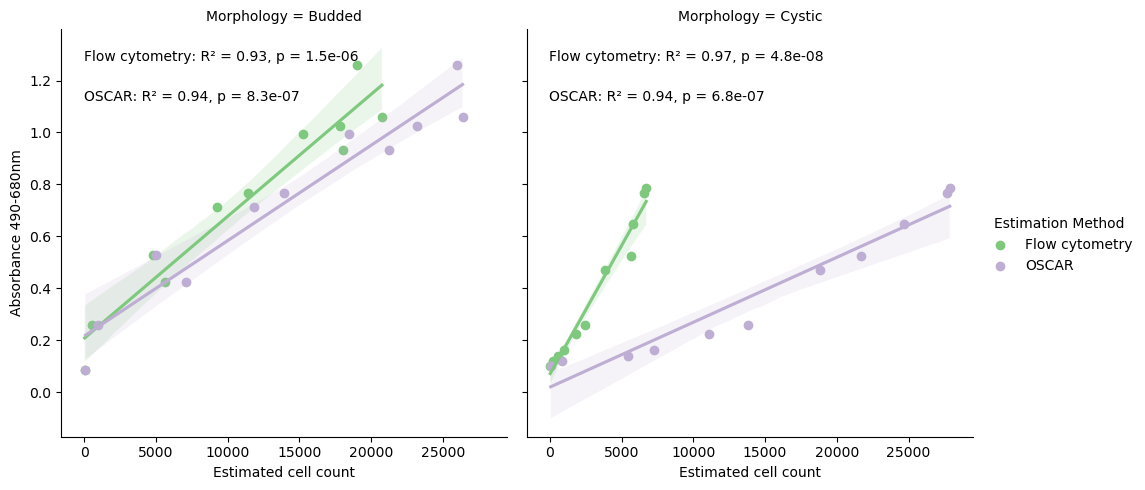

In [26]:

import statsmodels.api as sm

def get_regression_stats(x, y):
    x = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, x).fit()
    return model.rsquared, model.pvalues[1]  # R-squared and p-value for the slop

g = sn.lmplot(data = lysed_data, 
           x ='value', 
           y='LDH_measurement',
           hue = 'Estimation Method',
               col ='Morphology',
           scatter_kws= {'alpha': 1},
              palette = 'Accent',
              ci = 95)
g.set(xlabel='Estimated cell count',
       ylabel='Absorbance 490-680nm')

# Annotate each subplot with R² and p-values
for ax in g.axes.flat:
    # Get the category for the current axis
    category = ax.get_title().split(' = ')[1]  # Get the category from the title
    sub_data = lysed_data[lysed_data['Morphology'] == category]
    
    # Calculate R² and p-value for each category
    for cat in lysed_data['Estimation Method'].unique():
        subset = sub_data[sub_data['Estimation Method'] == cat]
        r_squared, p_value = get_regression_stats(subset['value'], subset['LDH_measurement'])
        ax.annotate(f'{cat}: R² = {r_squared:.2f}, p = {p_value:.2g}', 
                    xy=(0.05, 0.95 - 0.1 * list(lysed_data['Estimation Method'].unique()).index(cat)), 
                    xycoords='axes fraction', 
                    fontsize=10, 
                    ha='left', 
                    va='top')
plt.savefig(r'E:\Organoid_paper_final_images\comparison_count_methods_LDH_assay.png', dpi=250,bbox_inches = "tight")
plt.show()



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


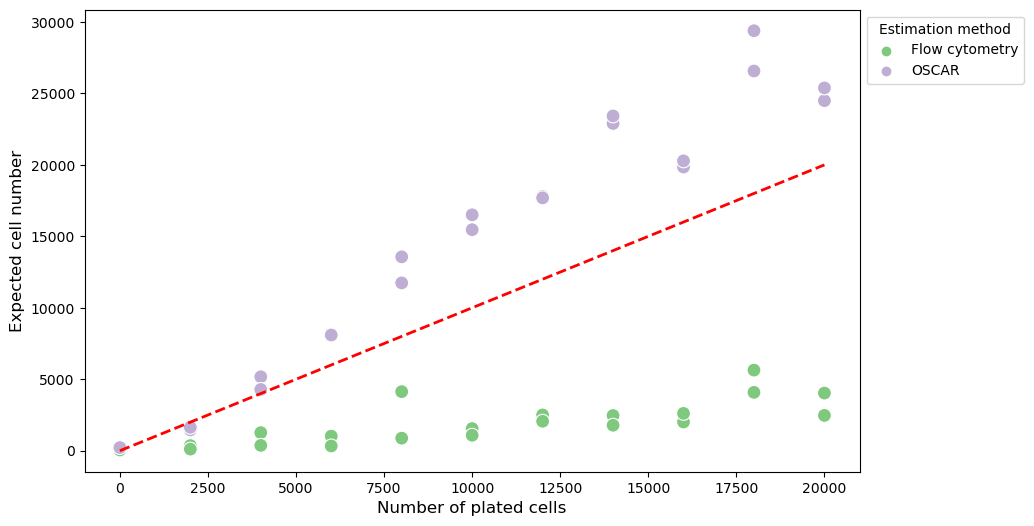

In [27]:
# This didn't make the paper


# # Plot Flow vs OSCAR counts to highlight difference between these two esp in the nonlysed setting
# ldh_data = pd.merge(ldh_counts, oscar_counts, on=['Lysed_status','Replicate','Cell_number_plated'], how='inner')
# ldh_data = ldh_data.melt(id_vars=['Lysed_status','Experiment_x','Replicate','Cell_number_plated','LDH_measurement'], value_vars=['Flow_count', 'OSCAR_count'])
# #ldh_data = ldh_data.groupby(['Lysed_status','Cell_number_plated','variable'])['LDH_measurement', 'value'].mean().reset_index()

# nonlysed_data = ldh_data[ldh_data['Lysed_status'] == 'Nonlysed']
# nonlysed_data = nonlysed_data.groupby(['Experiment_x','Cell_number_plated','variable'])['LDH_measurement', 'value'].mean().reset_index()


# from scipy.optimize import curve_fit
# import numpy as np

# # Plot Flow vs OSCAR counts to highlight difference between these two esp in the nonlysed setting
# ldh_data = pd.merge(ldh_counts, oscar_counts, on=['Lysed_status','Replicate','Cell_number_plated'], how='inner')
# ldh_data = ldh_data.melt(id_vars=['Lysed_status','Experiment_x','Replicate','Cell_number_plated','LDH_measurement'], value_vars=['Flow_count', 'OSCAR_count'])
# #ldh_data = ldh_data.groupby(['Lysed_status','Cell_number_plated','variable'])['LDH_measurement', 'value'].mean().reset_index()

# nonlysed_data = ldh_data[ldh_data['Lysed_status'] == 'Nonlysed']
# nonlysed_data = nonlysed_data.groupby(['Experiment_x','Cell_number_plated','variable'])['LDH_measurement', 'value'].mean().reset_index()
# nonlysed_data['variable'] = nonlysed_data['variable'].map({'Flow_count': 'Flow cytomeatry', 'OSCAR_count': 'OSCAR'})
# nonlysed_data['Cell_number_plated'] = nonlysed_data['Cell_number_plated'].astype(float)

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# g = sn.scatterplot(data=nonlysed_data, x='Cell_number_plated', y='value', hue='variable', s=100, palette = 'Accent')
# plt.xlabel('Number of plated cells', fontsize=12)
# plt.ylabel('Expected cell number', fontsize=12)

# # Given x and y values for the curve of best fit
# x_values = np.array([0, 2000, 4000, 6000, 8000, 10000,12000,14000,16000,18000,20000])
# y_values = np.array([0, 2000, 4000, 6000, 8000, 10000,12000,14000,16000,18000,20000])

# # Fit a polynomial of degree 1 (linear fit)
# coefficients = np.polyfit(x_values, y_values, 1)
# polynomial = np.poly1d(coefficients)

# # Generate smooth points for plotting the curve
# x_fit = np.linspace(0, 20000, 100)
# y_fit = polynomial(x_fit)
# g.plot(x_fit, y_fit, 'r--', label='Best Fit Curve', linewidth=2)



# # Get the handles and labels. For this example it'll be 2 tuples
# # of length 4 each.
# handles, labels = g.get_legend_handles_labels()

# # When creating the legend, only use the first two elements
# # to effectively remove the last two.
# l = plt.legend(handles[1:3], 
#                labels[1:3], 
#                bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
#                title = 'Estimation method')
# sn.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
# plt.savefig(r'E:\Organoid_paper_final_images\comparison_count_methods.png', dpi=250,bbox_inches = "tight")


# 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


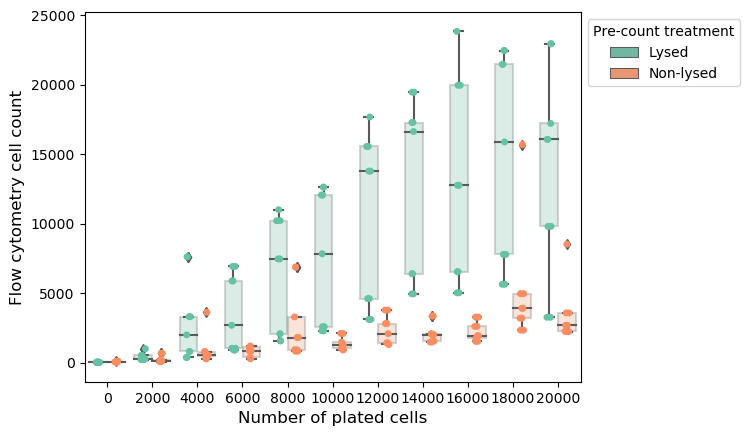

In [28]:
# Illustrating the variability in flow based counting methods

temp = ldh_data[ldh_data['variable'] =='Flow_count']
# Pivot the DataFrame
#temp.pivot(index='Experiment_x', columns='Lysed_status', values='value')

import pandas as pd
import matplotlib.pyplot as plt

# Group data by experiment and lysate status, get the mean of value
#mean_vals = temp.groupby(['Experiment_x','Cell_number_plated', 'Lysed_status'])['value'].mean().reset_index()
mean_vals = temp
mean_vals['Lysed_status'] = mean_vals['Lysed_status'].map({'Lysed': 'Lysed', 'Nonlysed': 'Non-lysed'})
mean_vals = mean_vals.rename(columns={'Lysed_status': 'Pre-count treatment'})

# Create a bar chart of means of each group with error bars
ax = sn.boxplot(x="Cell_number_plated", y="value", hue="Pre-count treatment", 
                data=mean_vals, palette ='Set2', boxprops=dict(alpha=0.25))
ax = sn.stripplot(x="Cell_number_plated", y="value", hue="Pre-count treatment", data=mean_vals,
            dodge = True, alpha = 1, palette ='Set2')

plt.xlabel('Number of plated cells', fontsize=12)
plt.ylabel('Flow cytometry cell count', fontsize=12)

handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], 
               labels[0:2], 
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               title = 'Pre-count treatment')
sn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(r'E:\Organoid_paper_final_images\lysed_vs_nonlysed_flow_counts.png', dpi=250,bbox_inches = "tight")

In [ ]:
# example code showing how the eMLR model is applied to csv files output by the MaskRCNN model 


import glob
import pandas as pd
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOuta
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm


#get all paths of images of interest

def merge_csv_files(directory_path, output_file, morphology_value, sample_type_value):
    # List to hold individual DataFrames
    data_frames = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            # Construct full file path
            file_path = os.path.join(directory_path, filename)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)

            # Create new columns with specified values
            well_id = os.path.splitext(filename)[0]
            df['Well_ID'] = well_id
            df['Morphology'] = morphology_value
            df['Tissue_type'] = sample_type_value

            # Move the new columns to the first positions
            df = df[['Well_ID', 'Morphology', 'Tissue_type'] + [col for col in df.columns if col not in ['Well_ID', 'Morphology', 'Tissue_type']]]

            # Append the DataFrame to the list
            data_frames.append(df)

    # Concatenate all DataFrames in the list
    merged_df = pd.concat(data_frames, ignore_index=True)

    # Save the merged DataFrame to a new CSV file
    merged_df.to_csv(output_file, index=False)
    return(merged_df)



def create_new_folder(directory_path, new_folder_name):
    # Construct the path for the new folder
    new_folder_path = os.path.join(directory_path, new_folder_name)

    try:
        # Create the new folder
        os.makedirs(new_folder_path)
        print(f"Folder '{new_folder_name}' created successfully in '{directory_path}'.")
    except FileExistsError:
        print(f"Folder '{new_folder_name}' already exists in '{directory_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


directory_path = r'C:\Users\Admin\Downloads\OneDrive_1_11-13-2024'  # replace with the path to your directory
scaling_factor = 1.5



create_new_folder(directory_path, 'results')

output_path = directory_path + '/results/organoid_area_estimates.csv'

morphology_value = 'Cystic'  # replace with the actual value for Morphology
tissue_type_value = 'Tumour'  # replace with the actual value for Sample_type

data = merge_csv_files(directory_path, output_path, morphology_value, tissue_type_value)


#data = pd.read_csv(r'I:\EVOS\110624\stitched\combined_counts.csv')
data['Dummy_tissue_type'] = data['Tissue_type'].map({'Healthy':0, 'Tumour':1})
data['Dummy_morphology'] = data['Morphology'].map({'Cystic':0, 'Budded':1})

filename = r'E:\mask_rcnn\MLR_model\mlr_model.sav'
#load model from disk
loaded_model = pickle.load(open(filename, 'rb'))


data_pre_analysis= data.drop(['Tissue_type',
                                     'Morphology',
                                    'Organoid_ID'], axis=1)



data_pre_analysis = data_pre_analysis.rename(columns={"Dummy_morphology": "Organoid Morphology", "Dummy_tissue_type": "Sample type"})
#data_pre_analysis['Area (pixels)'] = np.log10(data_pre_analysis['Area (pixels)'])



x = data_pre_analysis[['Area (pixels)', 'Sample type', 'Organoid Morphology']]
x['Area (pixels)'] = np.log10(x['Area (pixels)'])
# add constant
# with statsmodels
x = sm.add_constant(x,has_constant='add') # adding a constant
predictions = loaded_model.predict(x)
predictions = 10 ** predictions

#well_1_data_pre_analysis['ID'] = well_1_data['ID']
data_pre_analysis['cell_number'] = [int(x) for x in round(predictions)]
#data_pre_analysis['Area (pixels)'] = 10**data_pre_analysis['Area (pixels)']
#data_pre_analysis['cell_number'] = 10**data_pre_analysis['cell_number']

cell_counts = data_pre_analysis.groupby('Well_ID').sum().drop(['Sample type','Organoid Morphology','Area (pixels)'], axis=1)

cell_counts.rename(columns={'cell_number': 'Total_estimated_number_of_cells'}, inplace=True)

cell_counts['Total_estimated_number_of_cells'] = cell_counts['Total_estimated_number_of_cells']/(scaling_factor*scaling_factor)


output_path = directory_path + '/results/cell_counts.csv'
cell_counts.to_csv(output_path, index=True)

print('Analysis completed! Thank you for using OSCAR.')

